In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from minisom import MiniSom
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from rdkit.Chem.Descriptors import ExactMolWt
from utilities import tokenizer as tkn

from utilities.config import Config

config = Config()

np.set_printoptions(suppress=True)

# 方案一： 设置diff阈值； 方案二：设置保存的特征数，大的更容易保存
# threshold = 0.28
# num_features = 5


### 查看smiles分子

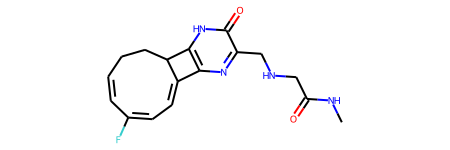

In [20]:
mol = Chem.MolFromSmiles('COC(=O)c1ccc(NC(=O)CCOc2ccccc2)cc1Cl')
mol

### 统计Zinc和LA的 MACCS Keys 分子指纹

In [3]:
# read the molecules from LA and zinc files, c

# 读取LA的smiles分子式
LA_list = []
with open(config.LA_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        LA_list.append(line.strip())

# 读取zinc的smiles分子式
zinc_list = []
with open(config.zinc_file, 'r', encoding='utf-8') as f:
    for line in f:
        zinc_list.append(line.strip().split(',')[0])
        
zinc_sampled_list = random.sample(zinc_list, 5*len(LA_list))

LA_mol_wt = []
# 生成LA的分子指纹
LA_fingerprint = []
for idx,sm in enumerate(LA_list):
    mol = Chem.MolFromSmiles(sm)
    LA_mol_wt.append(ExactMolWt(mol))
    try:
        fp = [x for x in MACCSkeys.GenMACCSKeys(mol)]
        LA_fingerprint.append(fp)
    except:
        print("Error", idx)

# 生成zinc的分子指纹
zinc_fingerprint = []
for idx,sm in enumerate(zinc_sampled_list):
    mol = Chem.MolFromSmiles(sm)
    try:
        fp = [x for x in MACCSkeys.GenMACCSKeys(mol)]
        zinc_fingerprint.append(fp)
    except:
        print("Error", idx)
        
        
LA_fingerprint = np.array(LA_fingerprint).astype(np.float64)
zinc_fingerprint = np.array(zinc_fingerprint).astype(np.float64)


RDKit WARNING: [19:45:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:45:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:45:08] WARNING: not removing hydrogen atom without neighbors


In [4]:
# 对167位分子指纹进行数量统计,除以样本数量以正则化

# 计算每一位的个数
LA_sum = np.sum(LA_fingerprint, axis=0)
zinc_sum = np.sum(zinc_fingerprint, axis=0)
# 计算差值，
diff = LA_sum/LA_fingerprint.shape[0] - zinc_sum/zinc_fingerprint.shape[0]

# 利用threshold计算下标
# idxs = np.where(np.abs(diff) >= threshold)[0]
# 利用som_num_features计算下标
idxs = np.argsort(np.abs(diff))[::-1][:config.som_num_features]

diff[idxs]
# # 抽出新的分子指纹
# new_LA_fp = LA_fingerprint[:, idxs[0]]
# new_zinc_fp = zinc_fingerprint[:, idxs[0]]

array([-0.41428571,  0.36363636, -0.32467532,  0.3017316 , -0.2995671 ])

### 重新抽取数据，并进行SOM训练

In [5]:
# 重新抽取LA和zinc数据集，1:1

LA_list = []
with open(config.LA_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        LA_list.append(line.strip()+",LA")
        
zinc_list = []
with open(config.zinc_file, 'r', encoding='utf-8') as f:
    for line in f:
        zinc_list.append(line.strip().split(',')[0] + ",OTHER")
        
zinc_sampled_list = random.sample(zinc_list, len(LA_list))
smile_list = LA_list + zinc_sampled_list
random.shuffle(smile_list)

# 将抽取结果保存至文件
with open(config.SOM_smiles_file, 'w', encoding='utf-8') as f:
    for sm in smile_list:
        f.write(sm+'\n')

In [6]:
train_smiles_list = []
label_list = []
with open(config.SOM_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        smile, label = line.strip().split(',')
        train_smiles_list.append(smile)
        label_list.append(0 if label != 'LA' else 1)
        
print("There are "+ str(len(train_smiles_list)) +" smile molecules in total!")
print("The rectangle size should be at least: " + str(math.ceil(np.sqrt(5 * np.sqrt(len(train_smiles_list))))))

There are 924 smile molecules in total!
The rectangle size should be at least: 13


In [7]:
fingerprint_list = []
for idx,sm in enumerate(train_smiles_list):
    mol = Chem.MolFromSmiles(sm)
    try:
        fp = [x for x in MACCSkeys.GenMACCSKeys(mol)]
        fingerprint_list.append(fp)
    except:
        print("Error", idx)
        
fingerprints = np.array(fingerprint_list).astype(np.float64)
fps = fingerprints[:, idxs]
labels = np.array(label_list)

RDKit WARNING: [20:44:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:44:08] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:44:08] WARNING: not removing hydrogen atom without neighbors


In [8]:
size = 18
som = MiniSom(size, size, fps.shape[1], sigma=3, learning_rate=0.5, neighborhood_function='triangle')
# som.pca_weights_init(fps)
som.random_weights_init(fps)
som.train(fps, 5000, random_order=True, verbose=True)
winmap = som.labels_map(fps,labels)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 4.006235871814284e-05


/home/ljy/.conda/envs/rdkit/lib/python3.9/site-packages/minisom.py:486: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


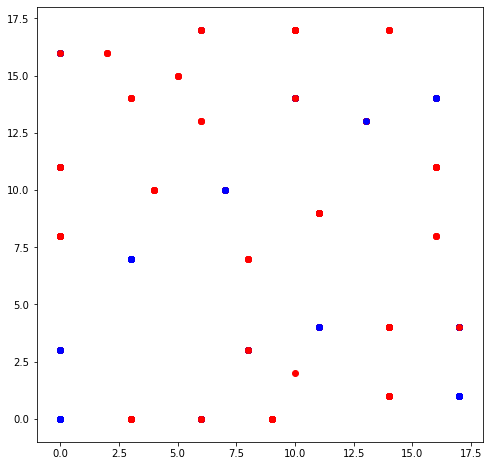

In [9]:
plt.figure(figsize=(8, 8))
wmap = {}
im = 0

for x, t in zip(fps, labels):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt.scatter(w[0],  w[1], color='red' if t==0 else 'blue')
    im = im + 1
plt.axis([-1, som.get_weights().shape[0], -1,  som.get_weights().shape[1]])
plt.show()

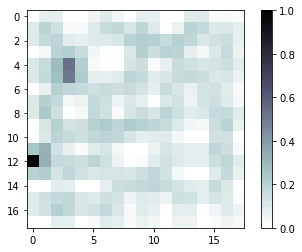

In [10]:
heatmap = som.distance_map()
plt.imshow(heatmap, cmap='bone_r')
plt.colorbar()

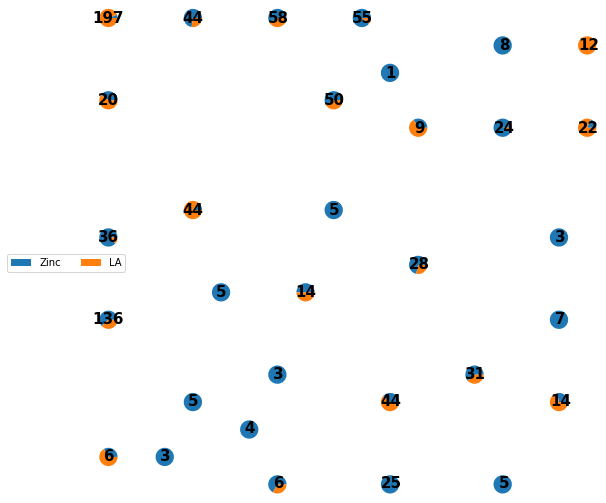

In [11]:
label_name_map_number = {"LA":1,"Zinc":0}
class_names = ["Zinc", "LA"]

from matplotlib.gridspec import GridSpec
plt.figure(figsize=(9, 9))
the_grid = GridSpec(size, size)
for position in winmap.keys():
    label_fracs = [winmap[position][label] for label in [0,1]]
    plt.subplot(the_grid[position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
    plt.text(position[0]/100, position[1]/100,  str(len(list(winmap[position].elements()))),
              color='black', fontdict={'weight': 'bold',  'size': 15},
              va='center',ha='center')
plt.legend(patches, class_names, loc='center right', bbox_to_anchor=(-1,9), ncol=3)
plt.show()


In [12]:
winmap

defaultdict(list,
            {(10, 14): Counter({1: 27, 0: 17}),
             (7, 10): Counter({0: 7, 1: 7}),
             (0, 0): Counter({1: 186, 0: 11}),
             (3, 7): Counter({1: 38, 0: 6}),
             (0, 11): Counter({0: 84, 1: 52}),
             (0, 8): Counter({0: 32, 1: 4}),
             (3, 0): Counter({0: 32, 1: 12}),
             (11, 4): Counter({0: 3, 1: 6}),
             (3, 14): Counter({0: 5}),
             (13, 13): Counter({0: 19, 1: 12}),
             (11, 9): Counter({0: 20, 1: 8}),
             (6, 0): Counter({0: 34, 1: 24}),
             (16, 8): Counter({0: 3}),
             (0, 16): Counter({1: 4, 0: 2}),
             (10, 2): Counter({0: 1}),
             (9, 0): Counter({0: 49, 1: 6}),
             (17, 1): Counter({1: 12}),
             (10, 17): Counter({0: 25}),
             (16, 14): Counter({1: 10, 0: 4}),
             (14, 1): Counter({0: 8}),
             (8, 3): Counter({0: 29, 1: 21}),
             (16, 11): Counter({0: 7}),
             (

idea: 通过获取矩阵中每个参数的百分比，来确定哪个参数与某个target/label的相关性，从而决定这个参数在打分时的重要性。

### 查看收集到的LA分子的重量

<BarContainer object of 462 artists>

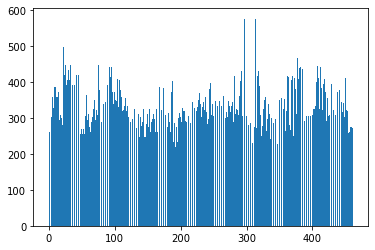

In [13]:
plt.bar(range(len(LA_mol_wt)), LA_mol_wt)

(array([ 18.,  89., 142.,  85.,  52.,  45.,  25.,   1.,   2.,   3.]),
 array([219.14918965, 254.87605671, 290.60292377, 326.32979084,
        362.0566579 , 397.78352496, 433.51039202, 469.23725908,
        504.96412615, 540.69099321, 576.41786027]),
 <BarContainer object of 10 artists>)

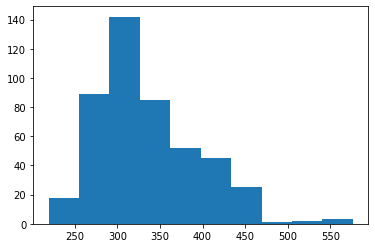

In [14]:
plt.hist(LA_mol_wt)

### 统计LA和Zinc的smiles分子长度

In [15]:
zinc_max_len = 0
zinc_len = []
for sm in zinc_list:
    zinc_len.append(len(sm))
    if len(sm) > zinc_max_len:
        zinc_max_len = len(sm)
        

LA_max_len = 0
LA_len = []
for sm in LA_list:
    LA_len.append(len(sm))
    if len(sm) > LA_max_len:
        LA_max_len = len(sm)

(array([     1.,     40.,   1189.,  33320., 318858., 685480., 689467.,
        196605.,  11798.,    205.]),
 array([12. , 17.1, 22.2, 27.3, 32.4, 37.5, 42.6, 47.7, 52.8, 57.9, 63. ]),
 <BarContainer object of 10 artists>)

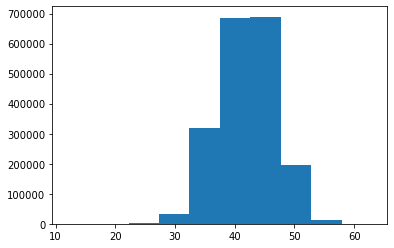

In [16]:
plt.hist(zinc_len)

(array([ 14., 115., 159.,  77.,  51.,  20.,  16.,   6.,   0.,   4.]),
 array([25. , 30.4, 35.8, 41.2, 46.6, 52. , 57.4, 62.8, 68.2, 73.6, 79. ]),
 <BarContainer object of 10 artists>)

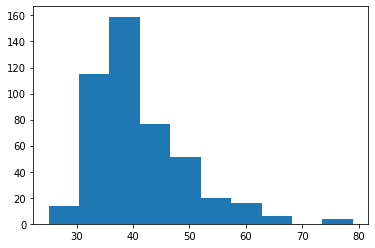

In [17]:
plt.hist(LA_len)

### 统计LA和zinc中有多少超过50长度的smiles

In [26]:
zinc_overL = [i for i, x in enumerate(zinc_len) if x > 50]
LA_overL = [i for i, x in enumerate(LA_len) if x > 50]
print(len(zinc_overL)/len(zinc_len), len(LA_overL)/len(LA_len))

0.02249242757863728 0.11688311688311688


### 统计字符

In [27]:
LA_list = []
with open(config.LA_smiles_file, 'r', encoding='utf-8') as f:
    for line in f:
        LA_list.append(line.strip())

LA_char = []
for i, sm in enumerate(LA_list):
    char_list = tkn.smiles_tokenizer(sm)
    LA_char = list(set(LA_char+list(set(char_list))))
    if 'I' in sm:
        print(i, sm)

print(LA_char)

186 CCCC[NH+]1CCCC1C(=O)Nc1ccccc1I
202 CCCCN1CCCC1C(=O)NCc1ccccc1I
['n', 'c', 'S', 'Cl', '+', '.', '2', '5', 's', '-', '7', ']', 'I', '[', '8', 'F', '1', '(', 'C', 'Br', 'H', 'N', 'o', '4', '#', ')', '3', 'O', '6', '=']


In [25]:
zinc_list = []
with open(config.zinc_file, 'r', encoding='utf-8') as f:
    for line in f:
        zinc_list.append(line.strip().split(',')[0])
        
zinc_list = zinc_list[1:]

zinc_char = []
for sm in zinc_list:
    char_list = tkn.smiles_tokenizer(sm.split(',')[0])
    zinc_char = list(set(zinc_char+list(set(char_list))))
    

print(zinc_char)

['2', '3', 'Cl', '1', '4', 'C', '=', '-', 'Br', '5', 'S', '#', 's', '[', 'O', 'n', 'o', ')', 'F', '(', 'c', 'N', ']', 'H', '6']


In [26]:
print(len(zinc_char), len(LA_char))

25 30


In [27]:
intersection = list(set(LA_char) & set(zinc_char))
difference = list(set(LA_char).difference(set(zinc_char)))
print(intersection, intersection==zinc_char)
print(difference)

['2', '3', 'Cl', '1', '4', 'C', '=', '-', 'Br', '5', 'S', '#', 's', '[', 'O', 'n', 'o', ')', 'F', '(', 'c', 'N', ']', 'H', '6'] True
['.', 'I', '7', '8', '+']
